<a href="https://colab.research.google.com/github/chanzone-khm/pytorch_study/blob/main/Pytorch%E5%8B%89%E5%BC%B7%E4%BC%9A_%E5%89%8D%E6%9C%9F%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題説明

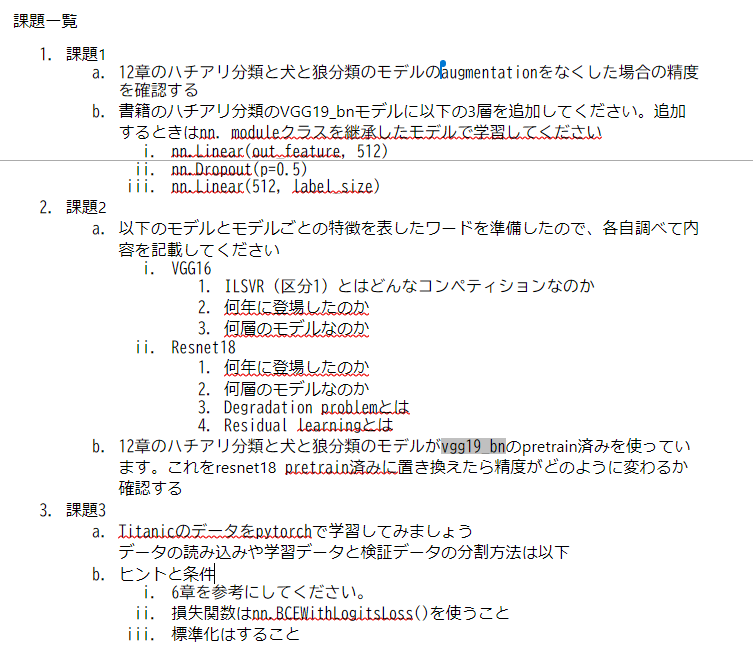

```python
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

titanic_dataset = sns.load_dataset('titanic') 
X = train[['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked', 'class', 'who', 'adult_male', 'alone']] 
y = train['survived'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
y_train, y_test = y_train.to_numpy(), y_test.to_numpy() 

#数値やラベルの処理 

#標準化 
def trans_standardscaler(input_train, input_test): 
    scaler = StandardScaler() 
    scaler.fit(input_train) 
    input_train = scaler.transform(input_train) 
    input_test = scaler.transform(input_test) 
    return input_train, input_test 
X_train, X_test, _ = trans_standardscaler(X_train, X_test) 

```

# import

In [1]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (1.7.0-5) ...


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [3]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 21.11 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Common Library for PyTorch
Author: M. Akaishi


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 課題1 ハチアリ

## a. 12章のハチアリ分類と犬と狼分類のモデルのaugmentationをなくした場合の精度を確認する 

### サンプルデータのダウンロード・回答

In [7]:
# サンプルデータのダウンロード
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 結果確認
print(w[-2])

2022-08-03 02:13:56 (106 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]


In [8]:
# データ解凍
w = !unzip -o hymenoptera_data.zip

# 結果確認
print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [9]:
# 解凍ファイルのtree表示
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

### transforms定義

In [24]:
# Transforms定義


# train transforms augmentation 無し
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

# test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


### DataLoader

In [25]:
# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [26]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [27]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


In [28]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

In [29]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [30]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04193 acc: 0.80328 val_loss: 0.01341, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.01683 acc: 0.93033 val_loss: 0.01171, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00469 acc: 0.98770 val_loss: 0.01241, val_acc: 0.94118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00188 acc: 0.99590 val_loss: 0.01420, val_acc: 0.94118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00194 acc: 0.99590 val_loss: 0.01477, val_acc: 0.92810


初期状態: 損失: 0.01341 精度: 0.96078
最終状態: 損失: 0.01477 精度: 0.92810


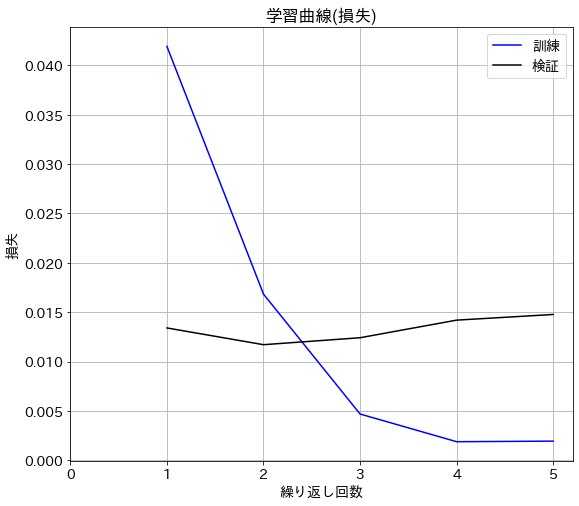

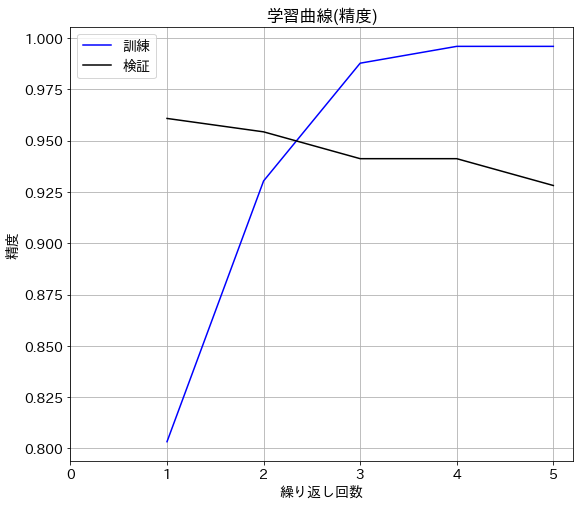

In [31]:
# 結果確認
evaluate_history(history)

augmentation ありのときの精度
* 初期状態: 損失: 0.01104 精度: 0.96078
* 最終状態: 損失: 0.01318 精度: 0.94771

augmentation なしのときの精度
* 初期状態: 損失: 0.01341 精度: 0.96078
* 最終状態: 損失: 0.01477 精度: 0.92810

## 課題2 オオカミ、いぬ

In [32]:
# データダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 解凍
!unzip dog_wolf.zip | tail -n 1

# 解凍結果のツリー表示
!tree dog_wolf

2022-08-03 01:28:02 (139 MB/s) - ‘dog_wolf.zip’ saved [21811374/21811374]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├─

### transforms

In [33]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [34]:
# データセット定義

data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)


In [35]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


In [36]:
# データローダー定義

batch_size = 5
# 学習データ
train_loader = DataLoader(train_data, 
            batch_size=batch_size, shuffle=True)
# 学習データ　イメージ表示用
train_loader2 = DataLoader(train_data2, 
            batch_size=40, shuffle=False)
# 検証データ
test_loader = DataLoader(test_data, 
            batch_size=batch_size, shuffle=False)
# 検証データ　イメージ表示用
test_loader2 = DataLoader(test_data, 
            batch_size=10, shuffle=True)

In [37]:
# 学習済みモデルの読み込み
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

lr = 0.001
# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [38]:
# 学習の実行

num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.11843 acc: 0.62500 val_loss: 0.08107, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.06555 acc: 0.90000 val_loss: 0.07606, val_acc: 0.70000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.02975 acc: 0.95000 val_loss: 0.03723, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.03671 acc: 0.95000 val_loss: 0.04293, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.03356 acc: 0.92500 val_loss: 0.07835, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.01711 acc: 1.00000 val_loss: 0.08290, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.01855 acc: 0.95000 val_loss: 0.08180, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.01325 acc: 1.00000 val_loss: 0.08665, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01129 acc: 0.97500 val_loss: 0.08128, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00393 acc: 1.00000 val_loss: 0.10123, val_acc: 0.80000


初期状態: 損失: 0.08107 精度: 0.90000
最終状態: 損失: 0.10123 精度: 0.80000


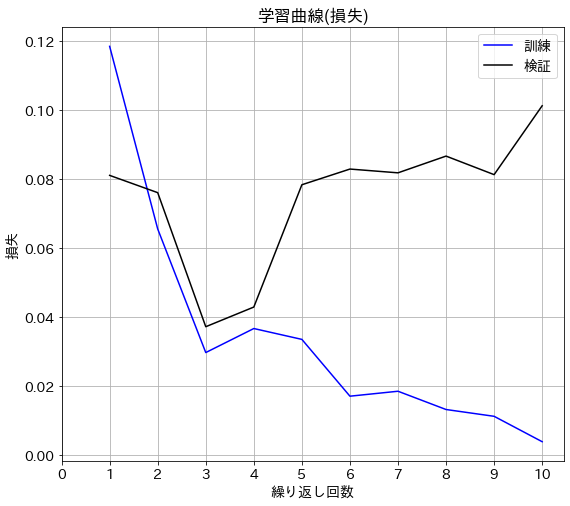

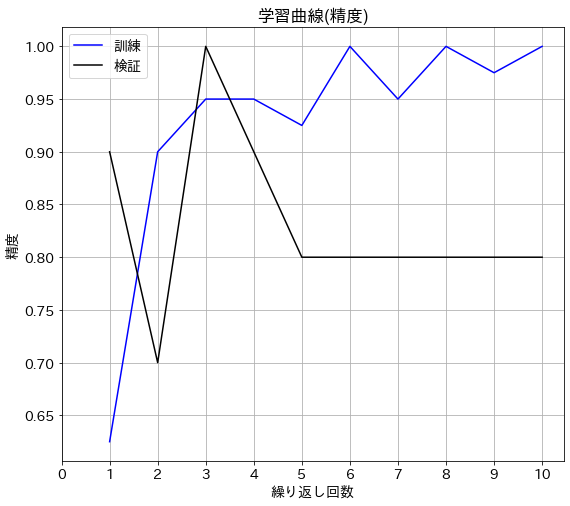

In [39]:
# 結果サマリー
evaluate_history(history)

augmentationありのとき
* 初期状態: 損失: 0.07783 精度: 1.00000
* 最終状態: 損失: 0.03189 精度: 1.00000

augmentation なしのとき
* 初期状態: 損失: 0.08107 精度: 0.90000
* 最終状態: 損失: 0.10123 精度: 0.80000

# 課題2 レイヤー追加

In [5]:
# Transforms定義


# train transforms augmentation 無し
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# test transforms
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])



In [6]:

# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [10]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [11]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


In [12]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

In [13]:
# vgg19_bnのsummary
from torchvision import models
net = models.vgg19_bn(pretrained = True)

print(net)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### 事前学習済モデルに3そうのレイヤーを追加

In [14]:
from torch.nn.modules.dropout import Dropout1d
# 事前学習済 3層のレイヤーを追加

class VGG19_bnAddDropout(nn.Module):
    
    def __init__(self, label_size):
        super().__init__()
        self.n_output = label_size

        self.backbone = models.vgg19_bn(pretrained = True)
        out_features = self.backbone.classifier[6].out_features
        self.l1 = nn.Linear(out_features, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(512, self.n_output)
        
        self.head = nn.Sequential(
            self.l1,
            self.dropout1,
            self.l2,
        )


    def forward(self, x):
        x1 = self.backbone(x)
        x2 = self.head(x1)
        return x2


In [15]:
net = VGG19_bnAddDropout(label_size = 2)
print(net)

VGG19_bnAddDropout(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, p

In [16]:
# 3層追加したモデルで学習する。

# 乱数初期化
torch_seed()

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# 
labels = 2
net = VGG19_bnAddDropout(labels)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [17]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.05997 acc: 0.75820 val_loss: 0.01627, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02936 acc: 0.86885 val_loss: 0.04674, val_acc: 0.81699


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02345 acc: 0.90164 val_loss: 0.01448, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02653 acc: 0.89344 val_loss: 0.02329, val_acc: 0.92157


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.02064 acc: 0.90574 val_loss: 0.02021, val_acc: 0.94771


初期状態: 損失: 0.01627 精度: 0.96078
最終状態: 損失: 0.02021 精度: 0.94771


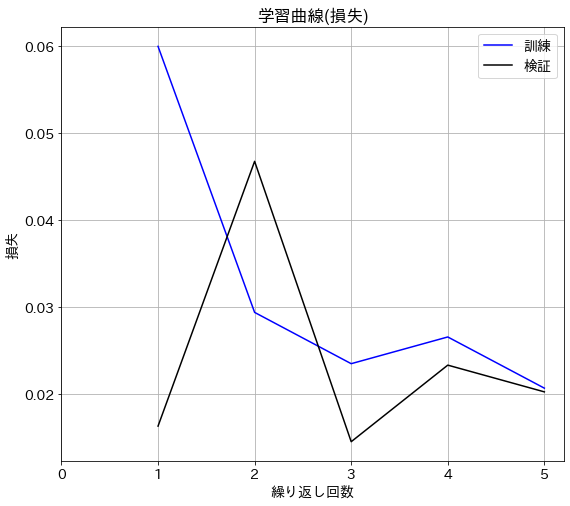

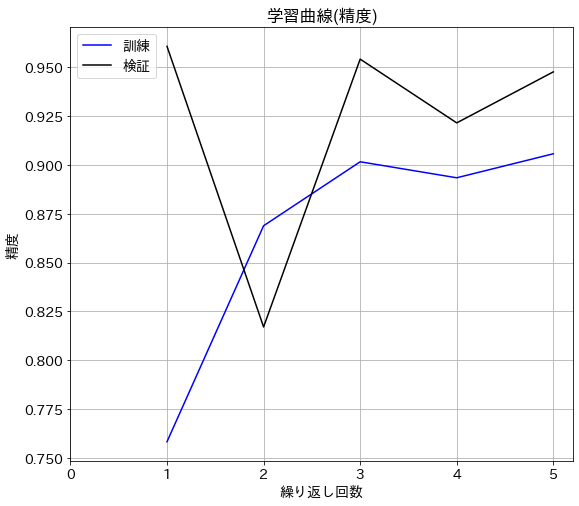

In [18]:
# 結果確認
evaluate_history(history)

augmentation あり vgg19_bn単体
* 初期状態: 損失: 0.01104 精度: 0.96078
* 最終状態: 損失: 0.01318 精度: 0.94771

augmentation あり vgg19_bn + dropout
* 初期状態: 損失: 0.01627 精度: 0.96078
* 最終状態: 損失: 0.02021 精度: 0.94771



◆VGG16 
* ILSVRC（区分1）とはどんなコンペティションなのか 
    * 1400万枚の画像を1000分類し精度を競うコンペ（TBD）
* 何年に登場したのか 
    * 2014年
* 何層のモデルなのか 
    * 16層のCNN

◆Resnet18  
* 何年に登場したのか 
    * 2015年
* 何層のモデルなのか 
    * 152層のCNN
* Degradation problemとは 
    * モデルの層が深いと、勾配が小さくなり学習が進まなくなる問題

* Residual learningとは
    * 残差学習
    * 出力と入力の差値を学習する
    * 学習したい関数をH(x)、 レイヤーの出力をF(x)、 入力値をxとおく
    * F(x) = H(x) - x
    * 変形して、 H(x) = F(x) + x
    * 学習が進むと、F(x) の出力は入力とほとんど差がなくなる。
    * xがあることによって、。。 TBD